In [8]:
import os
#os.chdir('/Users/rupesh.karn/Desktop/WorkPart-1/UNSW-NB15 Dataset')
import pandas as pd
import numpy as np
import csv
import os
import time
import matplotlib
matplotlib.use('agg')
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
pylab.rcParams['figure.figsize'] = (16.0, 5.0)
import sklearn
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
# for testing on CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
import tensorflow as tf
import pdb

# Read in the training CSV file
print "Reading Training csv file."
df1 = pd.read_csv("UNSW_NB15_training-set.csv")
df1.drop('label', axis=1, inplace=True)

#One hot encoding the string variables
obj_df1=df1
obj_df1["proto"] = obj_df1["proto"].astype('category')
obj_df1["service"] = obj_df1["service"].astype('category')
obj_df1["state"] = obj_df1["state"].astype('category')
obj_df1["proto_cat"] = obj_df1["proto"].cat.codes
obj_df1["service_cat"] = obj_df1["service"].cat.codes
obj_df1["state_cat"] = obj_df1["state"].cat.codes

obj_df1["proto"] = obj_df1["proto_cat"]
obj_df1["service"] = obj_df1["service_cat"]
obj_df1["state"] = obj_df1["state_cat"]

obj_df1.drop('proto_cat', axis=1, inplace=True)
obj_df1.drop('service_cat', axis=1, inplace=True)
obj_df1.drop('state_cat', axis=1, inplace=True)

Y_train_all_attacks = obj_df1["attack_cat"]
X_train = obj_df1.values[:,:-1]

#Normalizing train set
for j in range(0,43):
    maximum = max(X_train[:,j])
    for i in range(0,len(X_train)):
        X_train[i,j] = round(X_train[i,j]/maximum,3)

#Make a catagorical cloumn for each type of label in trainset
obj_df1=pd.get_dummies(obj_df1, columns=["attack_cat"])
Y_train_each_attach = obj_df1.values[:,-10:]
        
# Read in the testing CSV file 
print "Reading Testing csv file."
df2 = pd.read_csv("UNSW_NB15_testing-set.csv")
df2.drop('label', axis=1, inplace=True)

#One hot encoding the string variables
obj_df2=df2
obj_df2["proto"] = obj_df2["proto"].astype('category')
obj_df2["service"] = obj_df2["service"].astype('category')
obj_df2["state"] = obj_df2["state"].astype('category')
obj_df2["proto_cat"] = obj_df2["proto"].cat.codes
obj_df2["service_cat"] = obj_df2["service"].cat.codes
obj_df2["state_cat"] = obj_df2["state"].cat.codes

obj_df2["proto"] = obj_df2["proto_cat"]
obj_df2["service"] = obj_df2["service_cat"]
obj_df2["state"] = obj_df2["state_cat"]

obj_df2.drop('proto_cat', axis=1, inplace=True)
obj_df2.drop('service_cat', axis=1, inplace=True)
obj_df2.drop('state_cat', axis=1, inplace=True)

Y_test_all_attacks = obj_df2["attack_cat"]
X_test = obj_df2.values[:,:-1]

#Normalizing test set
for j in range(0,43):
    maximum = max(X_train[:,j])
    for i in range(0,len(X_test)):
        X_test[i,j] = round(X_test[i,j]/maximum,3)
        
#Make a catagorical cloumn for each type of label in testset
obj_df2=pd.get_dummies(obj_df2, columns=["attack_cat"])
Y_test_each_attach = obj_df2.values[:,-10:]

cleanup_nums = {"Worms":0, "Shellcode":1, "Reconnaissance":2, "Normal":3, "Generic":4, "Fuzzers":5, "Exploits":6, "DoS":7, "Backdoor":8, "Analysis":9}
Y_train_all_attacks.replace(cleanup_nums,inplace=True)
Y_test_all_attacks.replace(cleanup_nums,inplace=True)
print('Trainset size: ',X_train.shape,Y_train_all_attacks.shape,'Testset size: ',X_test.shape,Y_test_all_attacks.shape)
Y_train = Y_train_all_attacks 
Y_test = Y_test_all_attacks

Reading Training csv file.
Reading Testing csv file.
('Trainset size: ', (175341, 43), (175341,), 'Testset size: ', (82332, 43), (82332,))


In [16]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", Y_train.shape)
Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_test = np_utils.to_categorical(Y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

('Shape before one-hot encoding: ', (175341,))
('Shape after one-hot encoding: ', (175341, 10))


In [29]:
#Assigning the sparsity value to different layers. Sparsity: 1st hidden layer > 2nd hidden layer > output layer

model_losses = []
model_accs = []
layerwise_sparsity = []
model_sparsity = []
for sparsity in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99]:
    print('Model training for sparsity {0}'.format(sparsity))
    model = Sequential()
    model.add(Dense(160, input_shape=(43,), kernel_initializer='random_uniform',
                    bias_initializer='zeros'))
    model.add(Activation('relu'))                            
    model.add(Dense(80, kernel_initializer='random_uniform',
                    bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(Dense(10, kernel_initializer='random_uniform',
                    bias_initializer='zeros'))
    model.add(Activation('softmax'))

    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

    class LossHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.batches = []
            self.weight_save = []
            self.model_weights = model.get_weights()
            self.weight_masks = []
            for i in range(len(self.model_weights)):
                if i%2 == 0:
                    self.random_mask = np.ones(self.model_weights[i].shape)
                    self.random_mask[:int(self.model_weights[i].shape[0]*sparsity),:] = 0
                    np.random.shuffle(self.random_mask)
                    self.weight_masks.append(self.random_mask)
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[i/2])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights)     
            
            
        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.batches.append(batch)
            self.model_weights = model.get_weights()
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[i/2])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights) 

    l_history=LossHistory()
    history = model.fit(X_train, Y_train,
              batch_size=128, epochs=10, verbose=0,
              validation_data=(X_test, Y_test), callbacks = [es, l_history])

    loss_and_metrics = model.evaluate(X_test, Y_test, verbose=2)
    model_losses.append(loss_and_metrics[0])
    model_accs.append(loss_and_metrics[1])
    for i in range(len(model.get_weights())):
        if i%2==0:
            layerwise_sparsity.append(1 - float(np.count_nonzero(model.get_weights()[i]))/model.get_weights()[i].size)
    model_sparsity.append(layerwise_sparsity)
    layerwise_sparsity = []

Model training for sparsity 0.1
Model training for sparsity 0.2
Model training for sparsity 0.3
Model training for sparsity 0.4
Model training for sparsity 0.5
Model training for sparsity 0.6
Model training for sparsity 0.7
Model training for sparsity 0.8
Model training for sparsity 0.9
Model training for sparsity 0.92
Model training for sparsity 0.94
Model training for sparsity 0.96
Model training for sparsity 0.98
Model training for sparsity 0.99


In [30]:
print(model_sparsity)
print(model_accs)
print(model_losses)

[[0.09302325581395354, 0.09999999999999998, 0.09999999999999998], [0.18604651162790697, 0.19999999999999996, 0.19999999999999996], [0.2790697674418605, 0.30000000000000004, 0.30000000000000004], [0.39534883720930236, 0.4, 0.4], [0.4883720930232558, 0.5, 0.5], [0.5813953488372092, 0.6, 0.6], [0.6976744186046512, 0.7, 0.7], [0.7906976744186046, 0.8, 0.8], [0.8837209302325582, 0.9, 0.9], [0.9069767441860466, 0.91875, 0.9125], [0.9302325581395349, 0.9375, 0.9375], [0.9534883720930233, 0.95625, 0.95], [0.9767441860465116, 0.975, 0.975], [0.9767441860465116, 0.9875, 0.9875]]
[0.3747631540620709, 0.3831317106320942, 0.4416265850459117, 0.13709128892884184, 0.3819414079493362, 0.09099742505951514, 0.4184642666364871, 0.44939999028324346, 0.5571588203799636, 0.44939999028324346, 0.16956954768498275, 0.44939999028324346, 0.44939999028324346, 0.44939999028324346]
[10.077627079680171, 9.942741870712169, 8.999878893340808, 13.90844486913777, 9.961578978814797, 14.651390180396413, 8.974173028857692,

In [31]:
print(model.summary())
for i in range(len(model.get_weights())):
    print(model.get_weights()[i].shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 160)               7040      
_________________________________________________________________
activation_58 (Activation)   (None, 160)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 80)                12880     
_________________________________________________________________
activation_59 (Activation)   (None, 80)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 10)                810       
_________________________________________________________________
activation_60 (Activation)   (None, 10)                0         
Total params: 20,730
Trainable params: 20,730
Non-trainable params: 0
_________________________________________________________________
None
(

Sparsity =1-{non_zero_elements(matrix)}/{matrix.size}
Each neuron of respective hidden layer has equal constrained sparsity. 


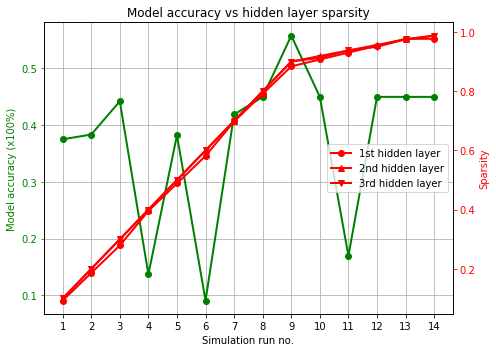

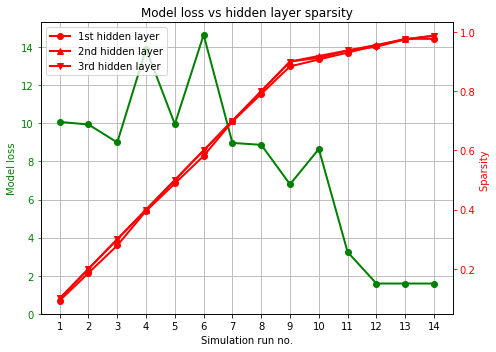

In [32]:
fig, ax1 = plt.subplots(figsize=(7,5))
X_axis = range(1,len(model_accs)+1)

ax1.plot(X_axis,model_accs,'go-', linewidth=2)
ax1.set_xlabel('Simulation run no.')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Model accuracy (x100%)', color='g')
ax1.tick_params('y', colors='g')
ax1.set_xticks(X_axis)
plt.grid(True)

ax2 = ax1.twinx()
ax2.plot(X_axis,[elem[0] for elem in model_sparsity],'ro-', linewidth=2, label = '1st hidden layer' ,marker = "o")
ax2.plot(X_axis,[elem[1] for elem in model_sparsity],'ro-', linewidth=2, label = '2nd hidden layer' ,marker = "^")
ax2.plot(X_axis,[elem[2] for elem in model_sparsity],'ro-', linewidth=2, label = '3rd hidden layer' ,marker = "v")
ax2.set_ylabel('Sparsity', color='r')
ax2.tick_params('y', colors='r')
plt.legend(loc='center right')
plt.title('Model accuracy vs hidden layer sparsity')
fig.tight_layout()

fig, ax1 = plt.subplots(figsize=(7,5))
X_axis = range(1,len(model_losses)+1)

ax1.plot(X_axis,model_losses,'go-', linewidth=2)
ax1.set_xlabel('Simulation run no.')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Model loss', color='g')
ax1.tick_params('y', colors='g')
ax1.set_xticks(X_axis)
ax1.set_yticks([0, 2, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.grid(True)

ax2 = ax1.twinx()
ax2.plot(X_axis,[elem[0] for elem in model_sparsity],'ro-', linewidth=2, label = '1st hidden layer' ,marker = "o")
ax2.plot(X_axis,[elem[1] for elem in model_sparsity],'ro-', linewidth=2, label = '2nd hidden layer' ,marker = "^")
ax2.plot(X_axis,[elem[2] for elem in model_sparsity],'ro-', linewidth=2, label = '3rd hidden layer' ,marker = "v")
ax2.set_ylabel('Sparsity ', color='r')
ax2.tick_params('y', colors='r')
plt.legend()
plt.title('Model loss vs hidden layer sparsity')
fig.tight_layout()
print('Sparsity =1-{non_zero_elements(matrix)}/{matrix.size}')
print('Each neuron of respective hidden layer has equal constrained sparsity. ')